# Dispatchable Renewable Electricity Offers Higher Energy Return on Investment than Carbon Capture and Storage Under Realistic Conditions 
*Sgouridis, Carbajales-Dale, Csala, Chiesa, Bardi*

Use this Jupyter workbook to reproduce all results presented in the paper.

<p>This is document has been created using  <a target="_blank" href="http://jupyter.org/">Jupyter Notebook</a> in the <a target="_blank" href="https://store.continuum.io/cshop/anaconda/">Anaconda</a> distribution and it can be edited and run in <i>active</i> mode by clicking download in top right corner of this page. The code is partitioned into sections, called <i>cells</i>. When you are using this workbook in <i>active</i> mode, double-click on a cell to edit it and then run using <code>Ctrl + Enter</code>. Hitting <code>Shift + Enter</code> runs the code and steps into the next cell, while <code>Alt + Enter</code> runs the code and adds a new, empty cell. If you are running this notebook on a presonal computer, you will need a machine with at least <i>1GB</i> of memory (<i>2GB</i> recommended) and a processor of <i>1GHz</i>.

Import dependencies

In [1]:
import pandas as pd, matplotlib.pyplot as plt, numpy as np
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as patches
import matplotlib.lines as lines
%matplotlib inline
import sys, string
from sympy import *
init_printing() 
print 'Running on Python',sys.version

Running on Python 2.7.15 |Anaconda, Inc.| (default, May  1 2018, 18:37:09) [MSC v.1500 64 bit (AMD64)]


### Fossil fuels part

#### Equations

In [2]:
var('EROEI E_out E_in');
eq_S1=Eq(EROEI,E_out/E_in)
eq_S1

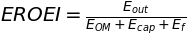

In [3]:
var('E_cap E_f E_OM');
eq_S1i=Eq(EROEI,E_out/(E_cap+E_OM+E_f))
eq_S1i

In [4]:
var('L s_OM');
eq_S2a=Eq(E_in,E_cap*(1+L*s_OM)+E_f)
eq_S2a

In [5]:
k=Symbol('kappa')
var('P L');
eq_S2b=Eq(E_out,P*k*L)
eq_S2b

In [6]:
var('E_el');
eq_S2bi=Eq(E_out,E_el)
eq_S2bi

In [7]:
e=Symbol('eta')
var('E_th');
eq_S2bii=Eq(E_th,P*k*L/e)
eq_S2bii

In [8]:
var('EROEI_th');
eq_S3i=Eq(E_f,E_th/EROEI_th)
eq_S3i

In [9]:
#define pretty variable substituion function
def sub(var,eq):
    return [var,solve(eq,var)[0]]
#create multiple substituion method by chaining
def multisub(eq0,msub):
    for i in range(len(msub)/2):
        eq0=eq0.subs([sub(msub[i*2],msub[i*2+1])])
    return eq0

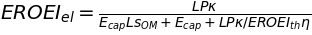

In [10]:
var('EROEI_el');
eq_S3=Eq(EROEI_el,multisub(eq_S1,[E_out,eq_S2b,E_in,eq_S2a,E_f,eq_S3i,E_th,eq_S2bii]).rhs)
eq_S3

In [11]:
#eq_S3 part 1 and eq_S4 not used

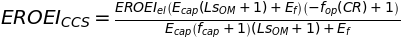

In [12]:
var('CR f_op EROEI_CCS f_cap');
eq_S5=Eq(EROEI_CCS,(1-f_op(CR))*(E_cap*(1+L*s_OM)+E_f)*EROEI_el/(E_cap*(1+f_cap)*(1+L*s_OM)+E_f))
eq_S5

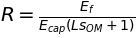

In [13]:
var('R');
eq_S6i=Eq(R,E_f/(E_cap*(1+L*s_OM)))
eq_S6i

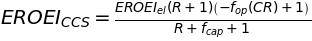

In [14]:
eq_S6=Eq(EROEI_CCS,(1-f_op(CR))*(R+1)*EROEI_el/(R+1+f_cap))
eq_S6

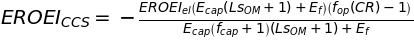

In [15]:
eq_S5.simplify()

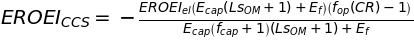

In [16]:
eq_S6.subs(R,eq_S6i.rhs).simplify()

In [17]:
#eq_S6 is correct!
eq_S6.subs(R,eq_S6i.rhs).simplify()==eq_S5.simplify()

True

#### Simulation

Using the formula in Eq.4 and the plant values from the Table S1 calculate the $EROEI_{el}$ for all capacity factors $CF$s between 50 and 90. We then use these values as a proxy to create an a adjustment factor for the $EROEI_{el}$ due to the indirect effect of the change of the capacity factor.

In [18]:
CFs=[50,55,60,65,70,75,80,85,90]
EROEI_els=[[8.8,9.2,8.8,10.7,11,26],
[9.2,9.6,9.2,11.2,11.5,27],
[9.6,10.1,9.7,11.6,12,27.8],
[10,10.5,10.1,12,12.4,28.6],
[10.3,10.8,10.5,12.4,12.8,29.3],
[10.7,11.1,10.8,12.7,13.2,29.9],
[11,11.5,11.2,13,13.5,30.5],
[11.2,11.7,11.5,13.3,13.8,31],
[11.5,12,11.8,13.5,14.1,31.5]]

In [19]:
df=pd.DataFrame(EROEI_els).T
df.columns=CFs
df.index.name='Plant #'
df.columns.name='CF'

In [20]:
df

CF,50,55,60,65,70,75,80,85,90
Plant #,,,,,,,,,
0,8.8,9.2,9.6,10.0,10.3,10.7,11.0,11.2,11.5
1,9.2,9.6,10.1,10.5,10.8,11.1,11.5,11.7,12.0
2,8.8,9.2,9.7,10.1,10.5,10.8,11.2,11.5,11.8
3,10.7,11.2,11.6,12.0,12.4,12.7,13.0,13.3,13.5
4,11.0,11.5,12.0,12.4,12.8,13.2,13.5,13.8,14.1
5,26.0,27.0,27.8,28.6,29.3,29.9,30.5,31.0,31.5


Capacity factor conversion ratio

In [21]:
(df[85]/df[55])/(85/55.0)

Plant #
0    0.787724
1    0.788603
2    0.808824
3    0.768382
4    0.776471
5    0.742919
dtype: float64

When we step up from CF 55 to 85, $EROEI_{el}$ only gets to 78% of what it should be using pure capacity factor conversion (85/55=1.54 multiplier). This is of course still dependent on the source EROEI, but let us use 0.78 for now, judging on the examined $EROEI$ ranges and the resultant conversion ratio values from the table above.

In [22]:
cf_conversion_ratio=np.mean((df[85]/df[55])/(85/55.0))

In [23]:
CF=[55,85]
CF_ratio=[1,cf_conversion_ratio]
CF_ratio

We need to create a similar ratio for the Capture ratio $CR$. We use the Energy penalty figure S1. We then use this value to adjust the fvalue of the operational energy penalty $f_{op}$.

|CR | energy penalty  |
|--|--|
|60| 7.8  |
|90| 11.8|

In [24]:
CR=[90,60]
CR_ratio=[1, 7.8/11.8]
CR_ratio

Define $EROEI_{CCS}$ calcuator function `eroei_ccs_cycler`, including minimums and maximums over $f_{op}$ and $f_{cap}$.

In [25]:
def eroei_ccs_cycler(names, eroei_els, t0s, CF, R, CR_ratio, fop, fcap, verbose=False):
    eroei_ccs=np.zeros([len(names),len(CF),len(CR_ratio),len(fop),len(fcap)])
    eroei_ccs_min=np.zeros([len(names),len(CF),len(CR_ratio)])+1000
    eroei_ccs_max=np.zeros([len(names),len(CF),len(CR_ratio)])
    for i in range(len(names)):
        for j in range(len(CF)):
            for r in range(len(CR_ratio)):
                for k in range(len(fop)):
                    for l in range(len(fcap)):
                        #calculate eoris over maps using eq_S6
                        eroei_ccs[i][j][r][l,k]=(1-fop[k]*CR_ratio[r]/100.0)*\
                            ((R[i][j]+1)/(R[i][j]+1+fcap[l]/100.0))*\
                            eroei_els[i]*CF[j]*CF_ratio[j]/100.0

                        #calculate min-maxes
                        for t0x in range(len(t0s[i])/2):
                            for t0y in range(len(t0s[i])/2,len(t0s[i])):
                                x=t0s[i][t0x]
                                y=t0s[i][t0y]
                                if ((abs(fop[k]-x)<0.5)and(abs(fcap[l]-y)<1.5)):
                                    eroei_ccs_max[i][j][r]=max(eroei_ccs_max[i][j][r],eroei_ccs[i][j][r][l,k])
                                    eroei_ccs_min[i][j][r]=min(eroei_ccs_min[i][j][r],eroei_ccs[i][j][r][l,k])
                if verbose:
                    print(names[i].replace('\n',' ')+': CF='+str(CF[j])+', CR='+str(CR[r])+\
                      ', EROEI_CCS - min='+str(np.round(eroei_ccs_min[i][j][r],2))+\
                      ', max='+str(np.round(eroei_ccs_max[i][j][r],2)))
    return eroei_ccs, eroei_ccs_min, eroei_ccs_max

Plot with relative $EROEI_{CCS}$ values, as percentages of base $EROEI$ for easy comparison across fuel types.

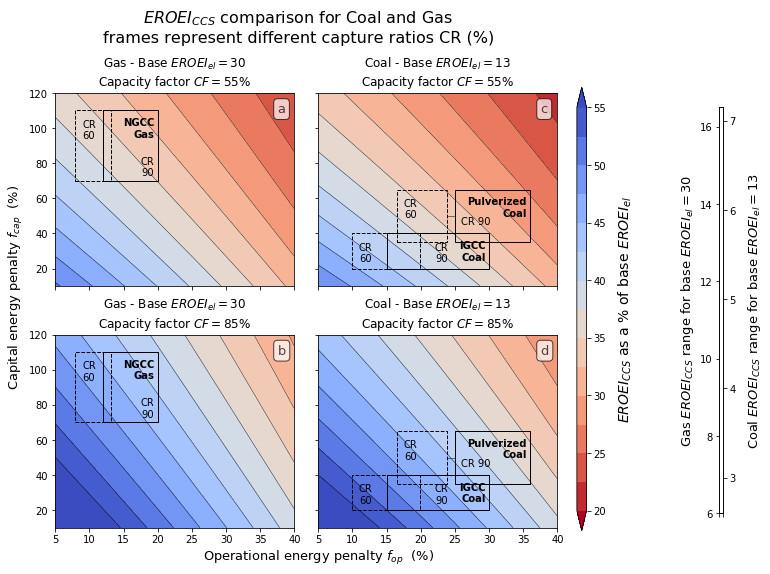

In [26]:
fop=np.linspace(5,40,100)
fcap=np.linspace(10,120,100)
R=[[1.7,2.5],[1.2,1.8],[0.9,1.5]] #varies by name and CF
title=u'$EROEI_{CCS}$ comparison for Coal and Gas'
eroei_els=[30,13,13] #varies by name
names=['NGCC\nGas','Pulverized\nCoal','IGCC\nCoal'] 
t0s=[[12,20,70,110],[25,36,35,65],[15,30,20,40]]  # [fop range [min,max], fcap] by each name

eroei_ccs, eroei_ccs_min, eroei_ccs_max=eroei_ccs_cycler(names, eroei_els, t0s, CF, R, CR_ratio, fop, fcap)

fig,axes=plt.subplots(2,2,figsize=(9,8))
plt.subplots_adjust(hspace=0.25)
plt.subplots_adjust(wspace=0.1)
eroei_ccs_scale_min=20
eroei_ccs_scale_max=55

for i in range(len(axes)):
    for j in range(len(axes[i])):
        eroei_el=eroei_els[j]
        ax=axes[i][j]
        X, Y = np.meshgrid(fop, fcap)
        z = eroei_ccs[j][i][0]*100.0/eroei_el #third index is CR, keep at 0, its relative
        levels = MaxNLocator(nbins=16).tick_values(eroei_ccs_scale_min,eroei_ccs_scale_max)
        levels2 = MaxNLocator(nbins=2).tick_values(eroei_ccs_scale_min,eroei_ccs_scale_max)
        cmap = plt.get_cmap('coolwarm_r')
        im = ax.contourf(X, Y, z, cmap=cmap, levels=levels,extend='both')
        im2 = ax.contour(X, Y, z, levels=levels,extend='both',colors='k',linewidths=0.4)
        im3 = ax.contour(X, Y, z, levels=levels2,extend='both',colors='k',linewidths=0.01)
        if (i==0)and(j==1):
            fig.subplots_adjust(right=0.9)
            cbar_ax = fig.add_axes([0.93, 0.12, 0.015, 0.77])
            fig.colorbar(im, cax=cbar_ax)
            cbar_ax.set_ylabel(u'$EROEI_{CCS}$ as a % of base $EROEI_{el}$',fontsize=14,labelpad=10)

            fig.subplots_adjust(right=0.9)
            aux_ax = fig.add_axes([1.15, 0.15, 0.005, 0.705])
            aux_ax.set_ylabel('Gas $EROEI_{CCS}$ range for base $EROEI_{el}='+\
                              str(eroei_els[0])+'$',fontsize=13)
            aux_ax.set_ylim(eroei_els[0]*eroei_ccs_scale_min/100.0,
                            eroei_els[0]*eroei_ccs_scale_max/100.0)
            aux_ax2=aux_ax.twinx()
            aux_ax2.set_ylabel('Coal $EROEI_{CCS}$ range for base $EROEI_{el}='+\
                               str(eroei_els[1])+'$',fontsize=13,labelpad=10)
            aux_ax2.set_ylim(eroei_els[1]*eroei_ccs_scale_min/100.0,
                             eroei_els[1]*eroei_ccs_scale_max/100.0)
            aux_ax.set_xticklabels('')   

        ax.set_xlim((fop.min(),fop.max()))
        ax.set_ylim((fcap.min(),fcap.max()))

        ls=['-','--']
        ls0='-'
        lw0=0.5
        t_x_offset=[6.5,3,8]
        t_y_offset=[37,20,16]
        breaker=['\n',' ','\n']
        for m in range(len(CR_ratio)):
            n=0
            for ti in range(len(t0s)):
                if (((j==1)and(ti==2))or(ti==j)):
                    t0=t0s[ti]
                    t=[t0[0]*CR_ratio[m],t0[1]*CR_ratio[m],t0[2]+n,t0[3]+n]
                    rect = patches.Rectangle((t[0],t[2]),t[1]-t[0],t[3]-t[2],ls=ls[m],
                                             edgecolor='k',facecolor='none')
                    ax.add_patch(rect)

                    if m==1:
                        ax.text(t[0]+2,t[3]-16,'CR\n'+str(CR[m]),horizontalalignment='center')
                    else:
                        ax.text(t[0]+t_x_offset[ti],t[3]-t_y_offset[ti],'CR'+breaker[ti]+str(CR[m]),
                                horizontalalignment='center')
                    if m==0: 
                        ax.text(t[1]-0.5,t[3]-15,names[ti],horizontalalignment='right',weight='bold')
                    if (ti==1)and(m==1):
                        line = lines.Line2D((t0[0],t[1]),((t0[2]+t0[3])/2,(t[2]+t[3])/2),color='k',
                                            linewidth=lw0,ls=ls0)
                        ax.add_line(line)  

        ax.set_title(names[j][names[j].find('\n'):]+' - Base $EROEI_{el}='+str(eroei_el)+\
                         u'$\nCapacity factor $CF='+str(CF[i])+'$%')
        ax.text(0.93, 0.95, string.ascii_lowercase[j*len(axes)+i],
            horizontalalignment='left',
            verticalalignment='top',
            transform=ax.transAxes,size=13,alpha=0.7,
                          bbox=dict(boxstyle="round", fc="w", alpha=0.7))
            
axes[1][1].set_xlabel('Operational energy penalty $f_{op}$  (%)',fontsize=13,x=0)
axes[0][0].set_ylabel('Capital energy penalty $f_{cap}$  (%)',fontsize=13,y=0)        
axes[0][1].set_yticklabels('')   
axes[1][1].set_yticklabels('')   
axes[0][0].set_xticklabels('')   
axes[0][1].set_xticklabels('')  
plt.suptitle(title+'\nframes represent different capture ratios CR (%)',fontsize=16,y=1.03)
plt.savefig('plot/fig2.png',dpi=150,bbox_inches = 'tight', pad_inches = 0.1)
plt.show()

Different style plot with actual EROEI values on the color maps, and also display _min_ and _max_ values for the $EROEI_{CCS}$.

NGCC Gas: CF=55, CR=90, EROEI_CCS - min=9.33, max=11.61
NGCC Gas: CF=55, CR=60, EROEI_CCS - min=10.13, max=12.13
NGCC Gas: CF=85, CR=90, EROEI_CCS - min=12.03, max=14.65
NGCC Gas: CF=85, CR=60, EROEI_CCS - min=13.06, max=15.31
Pulverized Coal: CF=55, CR=90, EROEI_CCS - min=3.5, max=4.65
Pulverized Coal: CF=55, CR=60, EROEI_CCS - min=4.18, max=5.17
Pulverized Coal: CF=85, CR=90, EROEI_CCS - min=4.43, max=5.76
Pulverized Coal: CF=85, CR=60, EROEI_CCS - min=5.29, max=6.41
IGCC Coal: CF=55, CR=90, EROEI_CCS - min=4.09, max=5.56
IGCC Coal: CF=55, CR=60, EROEI_CCS - min=4.69, max=5.88
IGCC Coal: CF=85, CR=90, EROEI_CCS - min=5.14, max=6.84
IGCC Coal: CF=85, CR=60, EROEI_CCS - min=5.9, max=7.23


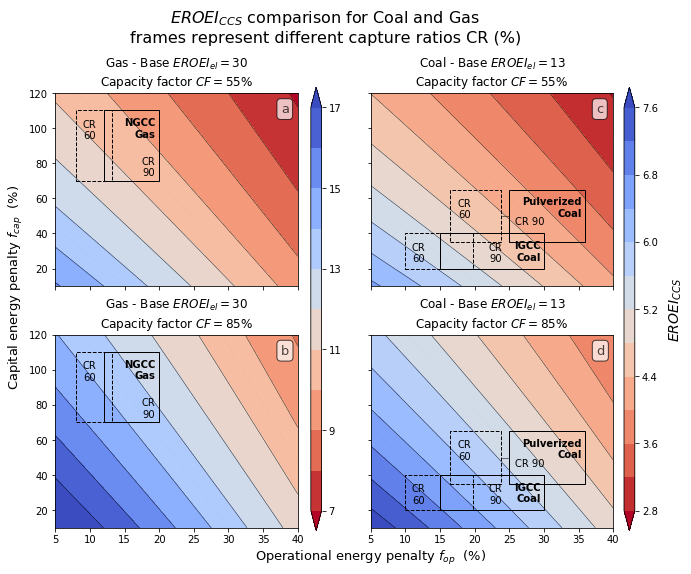

In [27]:
eroei_ccs, eroei_ccs_min, eroei_ccs_max=eroei_ccs_cycler(names, eroei_els, t0s, CF, R, CR_ratio, fop, fcap, verbose=True)

fig,axes=plt.subplots(2,2,figsize=(10,8))
plt.subplots_adjust(hspace=0.25)
plt.subplots_adjust(wspace=0.3)

for i in range(len(axes)):
    for j in range(len(axes[i])):
        eroei_el=eroei_els[j]
        ax=axes[i][j]
        X, Y = np.meshgrid(fop, fcap)
        z = eroei_ccs[j][i][0]#*100.0/eroei_el #third index is CR, keep at 0, its relative
        levels = MaxNLocator(nbins=12).tick_values(eroei_el/4, eroei_el/1.8)
        levels2 = MaxNLocator(nbins=8).tick_values(eroei_el/4, eroei_el/1.8)
        cmap = plt.get_cmap('coolwarm_r')
        im = ax.contourf(X, Y, z, cmap=cmap, levels=levels,extend='both')
        im2 = ax.contour(X, Y, z, levels=levels,extend='both',colors='k',linewidths=0.4)
        im3 = ax.contour(X, Y, z, levels=levels2,extend='both',colors='k',linewidths=0.01)
        ax.set_xlim((fop.min(),fop.max()))
        ax.set_ylim((fcap.min(),fcap.max()))
        if (i==0):
            fig.subplots_adjust(right=0.9)
            cbar_ax = fig.add_axes([0.48+0.435*j, 0.12, 0.015, 0.77])
            fig.colorbar(im, cax=cbar_ax)
            if j==1: cbar_ax.set_ylabel(u'$EROEI_{CCS}$',fontsize=14,labelpad=10)

        for m in range(len(CR_ratio)):
            n=0
            for ti in range(len(t0s)):
                if (((j==1)and(ti==2))or(ti==j)):
                    t0=t0s[ti]
                    t=[t0[0]*CR_ratio[m],t0[1]*CR_ratio[m],t0[2]+n,t0[3]+n]
                    rect = patches.Rectangle((t[0],t[2]),t[1]-t[0],t[3]-t[2],ls=ls[m],
                                             edgecolor='k',facecolor='none')
                    ax.add_patch(rect)

                    if m==1:
                        ax.text(t[0]+2,t[3]-16,'CR\n'+str(CR[m]),horizontalalignment='center')
                    else:
                        ax.text(t[0]+t_x_offset[ti],t[3]-t_y_offset[ti],'CR'+breaker[ti]+str(CR[m]),
                                horizontalalignment='center')
                    if m==0: 
                        ax.text(t[1]-0.5,t[3]-15,names[ti],horizontalalignment='right',weight='bold')
                    if (ti==1)and(m==1):
                        line = lines.Line2D((t0[0],t[1]),((t0[2]+t0[3])/2,(t[2]+t[3])/2),color='k',
                                            linewidth=lw0,ls=ls0)
                        ax.add_line(line)  

        ax.set_title(names[j][names[j].find('\n'):]+' - Base $EROEI_{el}='+str(eroei_el)+\
                         u'$\nCapacity factor $CF='+str(CF[i])+'$%')
        ax.text(0.93, 0.95, string.ascii_lowercase[j*len(axes)+i],
            horizontalalignment='left',
            verticalalignment='top',
            transform=ax.transAxes,size=13,alpha=0.7,
                          bbox=dict(boxstyle="round", fc="w", alpha=0.7))
            
axes[1][1].set_xlabel('Operational energy penalty $f_{op}$  (%)',fontsize=13,x=0)
axes[0][0].set_ylabel('Capital energy penalty $f_{cap}$  (%)',fontsize=13,y=0)        
axes[0][1].set_yticklabels('')   
axes[1][1].set_yticklabels('')   
axes[0][0].set_xticklabels('')   
axes[0][1].set_xticklabels('')  
plt.suptitle(title+'\nframes represent different capture ratios CR (%)',fontsize=16,y=1.03)
plt.savefig('plot/fig2b.png',dpi=150,bbox_inches = 'tight', pad_inches = 0.1)
plt.show()

### Dispatchable Renewables Part

#### Equations

In [28]:
l=Symbol('lambda')
epse=Symbol('epsilon_e')
var('ESOI D');
eq_S7=Eq(ESOI,l*e*D/epse)
eq_S7

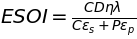

In [29]:
epsp=Symbol('epsilon_p')
epss=Symbol('epsilon_s')
var('D P C');
eq_S8=Eq(ESOI,C*l*e*D/(P*epsp+C*epss))
eq_S8

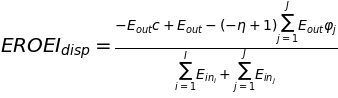

In [30]:
f=Symbol('varphi_j')
Ei=Symbol('E_{in_i}')
Ej=Symbol('E_{in_j}')
var('EROEI_disp c j i I J');
eq_S9=Eq(EROEI_disp,(E_out-(1-e)*Sum(f*E_out,(j,1,J))-c*E_out)/(Sum(Ei,(i,1,I))+Sum(Ej,(j,1,J))))
eq_S9

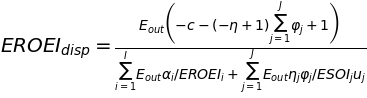

In [31]:
a=Symbol('alpha_i')
ej=Symbol('eta_j')
f=Symbol('varphi_j')
Ei=Symbol('E_{in_i}')
Ej=Symbol('E_{in_j}')
var('EROEI_i u_j ESOI_j');
eq_S10=Eq(EROEI_disp,(E_out*(1-(1-e)*Sum(f,(j,1,J))-c))/(Sum(E_out*a/EROEI_i,(i,1,I))+Sum((E_out*f*ej)/(ESOI_j*u_j),(j,1,J))))
eq_S10

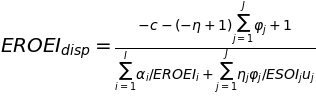

In [32]:
eq_S11=Eq(EROEI_disp,((1-(1-e)*Sum(f,(j,1,J))-c))/(Sum(a/EROEI_i,(i,1,I))+Sum((f*ej)/(ESOI_j*u_j),(j,1,J))))
eq_S11

#### Simulation

Define $EROEI_{disp}$ calcuator function `eroei_disp_cycler`, including minimums and maximums over $\varphi$.

In [33]:
def eroei_disp_cycler(ESOI, phi, eta, c, eroei_el):
    eroei_disp=np.zeros([len(ESOI),len(phi),len(eroei_el)])
    for i in range(len(ESOI)):
        for j in range(len(phi)):
            for k in range(len(eroei_el)):
                #eq_S11
                #Also Eq. 6 from http://pubs.rsc.org/en/content/articlepdf/2013/ee/c3ee41973h
                eroei_disp[i][k,j]=(-c[i]-(+1-eta[i])*phi[j]+1)/\
                                    ((1.0/eroei_el[k])+(eta[i]*phi[j]/ESOI[i]))    
    return eroei_disp

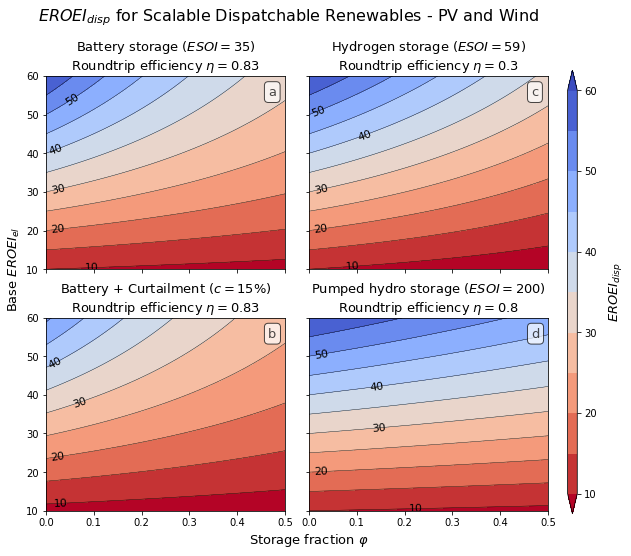

In [34]:
eroei_el=np.linspace(10,60,100)
phi=np.linspace(.0,.50,100)
ESOI=[35,59,35,200]
ESOI_tech=['Battery storage','Hydrogen storage','Battery + Curtailment','Pumped hydro storage']
eta=[0.83,0.3,0.83,0.8]
c=[0,0,0.15,0]

eroei_disp=eroei_disp_cycler(ESOI, phi, eta, c, eroei_el)

fig,axes=plt.subplots(2,2,figsize=(9,8))
plt.subplots_adjust(wspace=0.1)
plt.subplots_adjust(hspace=0.25)
contour_min=10
contour_max=60
for i in range(len(ESOI)):
        ax=axes[i/2][i%2]
        z = eroei_disp[i]
        levels = MaxNLocator(nbins=10).tick_values(contour_min, contour_max)
        levels2 = MaxNLocator(nbins=5).tick_values(contour_min, contour_max)
        cmap = plt.get_cmap('coolwarm_r')
        X, Y = np.meshgrid(phi, eroei_el)
        im = ax.contourf(X, Y, z, cmap=cmap, levels=levels,extend='both')
        im2 = ax.contour(X, Y, z, levels=levels,extend='both',colors='k',linewidths=0.4)
        im3 = ax.contour(X, Y, z, levels=levels2,extend='both',colors='k',linewidths=0.01)    
        ax.clabel(im3, fmt = '%i',inline=1, fontsize=11)
        if (i==0):
            fig.subplots_adjust(right=0.9)
            cbar_ax = fig.add_axes([0.93, 0.12, 0.015, 0.77])
            fig.colorbar(im, cax=cbar_ax)
            cbar_ax.set_ylabel(u'$EROEI_{disp}$',fontsize=13,labelpad=10)
        ax.set_xlim((phi.min(),phi.max()))
        ax.set_ylim((eroei_el.min(),eroei_el.max()))
        if (i!=2):
            ax.set_title(ESOI_tech[i]+u' ($ESOI='+str(ESOI[i])+\
                     '$)\nRoundtrip efficiency $\eta='+str(eta[i])+'$',fontsize=13)
        else:
            ax.set_title(ESOI_tech[i]+u' ($c='+str(int(c[i]*100))+\
                     '$%)\nRoundtrip efficiency $\eta='+str(eta[i])+'$',fontsize=13)
        ax.text(0.93, 0.95, string.ascii_lowercase[(i%2)*2+i/2],
                horizontalalignment='left',
                verticalalignment='top',
                transform=ax.transAxes,size=13,alpha=0.7,
                              bbox=dict(boxstyle="round", fc="w", alpha=0.7))
            
axes[1][1].set_xlabel('Storage fraction $\\varphi$',fontsize=13,x=0)
axes[0][0].set_ylabel('Base $EROEI_{el}$',fontsize=13,y=0)        
axes[0][1].set_yticklabels('')   
axes[1][1].set_yticklabels('')   
axes[0][0].set_xticklabels('')   
axes[0][1].set_xticklabels('')  
plt.suptitle(r'$EROEI_{disp}$ for Scalable Dispatchable Renewables - PV and Wind',fontsize=16,y=1)
plt.savefig('plot/fig3.png',dpi=150,bbox_inches = 'tight', pad_inches = 0.1)
plt.show()

Define convex hull function to get outermost points of sensitivity analysis area.

In [35]:
from scipy.spatial import ConvexHull

In [36]:
def convexhull(p):
    p = np.array(p)
    hull = ConvexHull(p)
    return p[hull.vertices,:]

Define wieldy color functions.

In [37]:
def cbrew(i):
    colors=['#984ea3',
            '#e41a1c',
            '#377eb8',
            '#4daf4a',
            '#ff7f00']
    return colors[i]

Define figure aspect ratio getter for labels.

In [38]:
from operator import sub
#https://stackoverflow.com/questions/41597177/get-aspect-ratio-of-axes#42014041
def get_aspect(ax):
    # Total figure size
    figW, figH = ax.get_figure().get_size_inches()
    # Axis size on figure
    _, _, w, h = ax.get_position().bounds
    # Ratio of display units
    disp_ratio = (figH * h) / (figW * w)
    # Ratio of data units
    # Negative over negative because of the order of subtraction
    data_ratio = sub(*ax.get_ylim()) / sub(*ax.get_xlim())

    return disp_ratio / data_ratio

Caclulate envelopes

In [39]:
#Fossil part
segments=100
eroei_el_ns=[np.linspace(10,32,segments),np.linspace(5,13,segments),np.linspace(8,16,segments)]   
eroei_ccs_N, eroei_ccs_min_N, eroei_ccs_max_N=[],[],[]
for i in range(len(names)):
    print 'calculating '+names[i].replace('\n',' ')+' area...'
    eroei_ccs_n, eroei_ccs_min_n, eroei_ccs_max_n=[],[],[]
    for eroi in range(len(eroei_el_ns[i])):
        eroei_ccs, eroei_ccs_min, eroei_ccs_max=\
                eroei_ccs_cycler([names[i]], [eroei_el_ns[i][eroi]], [t0s[i]], CF, [R[i]], CR_ratio, fop, fcap)
        eroei_ccs_n.append(eroei_ccs)
        eroei_ccs_min_n.append(eroei_ccs_min)
        eroei_ccs_max_n.append(eroei_ccs_max)
    eroei_ccs_N.append(eroei_ccs_n)
    eroei_ccs_min_N.append(eroei_ccs_min_n)
    eroei_ccs_max_N.append(eroei_ccs_max_n)
fs_top=max(np.array(eroei_ccs_max_N).flatten())

calculating NGCC Gas area...
calculating Pulverized Coal area...
calculating IGCC Coal area...


In [44]:
#RE part
eroei_el_ren=[np.linspace(9,30,segments),np.linspace(20,40,segments)]
eroei_ren_names=['PV','Wind']
eroei_disp_n=[]
re_bottom=[1000 for i in range(len(ESOI))]
for i in range(len(eroei_ren_names)):
    print 'calculating '+eroei_ren_names[i]+' area...'
    eroei_disp=eroei_disp_cycler(ESOI, phi, eta, c, eroei_el_ren[i])
    eroei_disp_n.append(eroei_disp)  
    for j in range(len(eroei_disp_n[i])):
        re_bottom[j]=min(re_bottom[j],min(np.array(eroei_disp_n[i][j]).flatten()))

calculating PV area...
calculating Wind area...


Plot areas

calculating NGCC Gas convex hull...
calculating Pulverized Coal convex hull...
calculating IGCC Coal convex hull...
calculating PV convex hull...
calculating Wind convex hull...


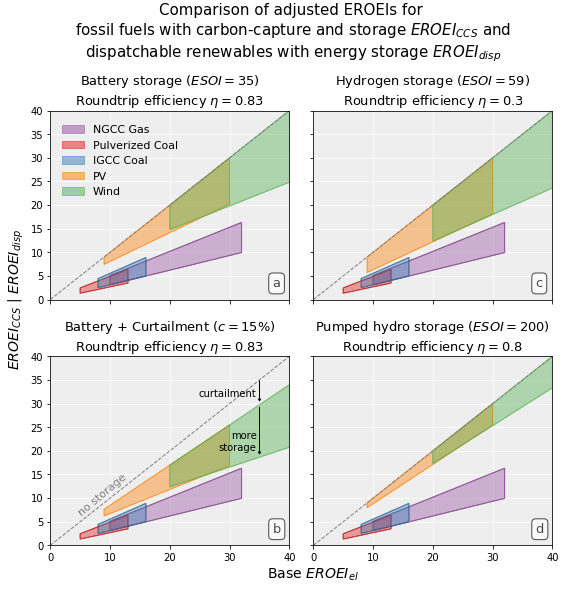

In [61]:
#Plots init
fig,axes=plt.subplots(2,2,figsize=(9,8),subplot_kw=dict(facecolor='#EEEEEE',axisbelow=True))
for axi in axes:
    for ax in axi:
        ax.grid(color='white', linestyle='solid')                       
plt.subplots_adjust(wspace=0.1)
plt.subplots_adjust(hspace=0.3)
legendalpha=0.5

#Fossil part
for i in range(len(names)):
    points=[]
    print 'calculating '+names[i].replace('\n',' ')+' convex hull...'
    for eroi in range(len(eroei_el_ns[i])):
        x0=eroei_el_ns[i][eroi]
        y0min=min(eroei_ccs_min_N[i][eroi].flatten())
        y0max=max(eroei_ccs_max_N[i][eroi].flatten())
        points.append([x0,y0min])
        points.append([x0,y0max])
                              
    for axi in axes:
        for ax in axi:
            colr=cbrew(i)
            poly = plt.Polygon(convexhull(points), edgecolor="k",facecolor=colr,alpha=0.4)
            poly2 = plt.Polygon(convexhull(points), edgecolor=colr,alpha=0.8,fill=False,lw=1)
            legendpoly = plt.Polygon([[0,0],[0,-1],[-1,-1]], edgecolor=colr,facecolor=colr,alpha=legendalpha,lw=1,label=names[i].replace('\n',' '))
            ax.add_patch(poly)
            ax.add_patch(poly2)
            ax.add_patch(legendpoly)

#RE part
for i in range(len(eroei_disp_n)):
    print 'calculating '+eroei_ren_names[i]+' convex hull...'
    for j in range(len(eroei_disp_n[i])):
        points=[]
        for eroi in range(len(eroei_disp_n[i][j])):
            x0=eroei_el_ren[i][eroi]
            y0min=min(eroei_disp_n[i][j][eroi].flatten())
            y0max=max(eroei_disp_n[i][j][eroi].flatten())
            points.append([x0,y0min])
            points.append([x0,y0max])

        colr=cbrew(4-i)
        ax=axes[j/2][j%2]
        poly = plt.Polygon(convexhull(points), edgecolor="none",facecolor=colr,alpha=0.4)
        poly2 = plt.Polygon(convexhull(points), edgecolor=colr,alpha=0.8,fill=False,lw=1)
        legendpoly = plt.Polygon([[0,0],[0,-1],[-1,-1]], edgecolor=colr,facecolor=colr,alpha=legendalpha,lw=1,label=eroei_ren_names[i])
        ax.add_patch(poly)
        ax.add_patch(poly2)
        ax.add_patch(legendpoly)
        if (i==0):
            if (j!=2):
                ax.set_title(ESOI_tech[j]+u' ($ESOI='+str(ESOI[j])+\
                     '$)\nRoundtrip efficiency $\eta='+str(eta[j])+'$',fontsize=13)
            else:
                ax.set_title(ESOI_tech[j]+u' ($c='+str(int(c[j]*100))+\
                     '$%)\nRoundtrip efficiency $\eta='+str(eta[j])+'$',fontsize=13)
            ax.text(0.93, 0.12, string.ascii_lowercase[(j%2)*2+j/2],
                    horizontalalignment='left',
                    verticalalignment='top',
                    transform=ax.transAxes,size=13,alpha=0.7,
                    bbox=dict(boxstyle="round", fc="w", alpha=0.7))
            ax.plot([0,100],[0,100],c='grey',lw=1,ls='--')
            if (j==2): 
                ax.text(0.22, 0.27, 'no storage',
                        horizontalalignment='center',
                        verticalalignment='center',
                        transform=ax.transAxes,size=11,rotation=40, color='grey')
                ax.arrow(35, 35, 0, -4, head_width=0.5, head_length=0.5, fc='k', ec='k',ls='-',lw=0.5)
                ax.arrow(35, 29.3, 0, -9.5, head_width=0.5, head_length=0.5, fc='k', ec='k',ls='-',lw=0.5)
                ax.text(34.5, 32, 'curtailment',
                        horizontalalignment='right',
                        verticalalignment='center', rotation=0, color='k')
                ax.text(34.5, 22, 'more\nstorage',
                        horizontalalignment='right',
                        verticalalignment='center', rotation=0, color='k')
            
#Format labels
for axi in axes:
    for ax in axi:
        ax.set_xlim(0,max(np.array(eroei_el_ren).flatten()))
        ax.set_ylim(0,max(np.array(eroei_el_ren).flatten()))
axes[0][0].set_ylabel('$EROEI_{CCS}$ | $EROEI_{disp}$',fontsize=14,y=0)
axes[1][1].set_xlabel('Base $EROEI_{el}$',fontsize=14,x=0)        
axes[0][1].set_yticklabels('')   
axes[1][1].set_yticklabels('')   
axes[0][0].set_xticklabels('')   
axes[0][1].set_xticklabels('')  
#axes[0][1].legend(loc=(1.04,0.58),fontsize=11)       
axes[0][0].legend(loc=(0.03,0.52),framealpha=0,fontsize=11)       
        
plt.suptitle('Comparison of adjusted EROEIs for \nfossil fuels with carbon-capture and storage $EROEI_{CCS}$ and \ndispatchable renewables with energy storage $EROEI_{disp}$',y=1.06,fontsize=15)
plt.savefig('plot/fig4.png',dpi=150,bbox_inches = 'tight', pad_inches = 0.1)
plt.show()

Annotated comparable area plots

calculating NGCC Gas convex hull...
calculating Pulverized Coal convex hull...
calculating IGCC Coal convex hull...
calculating PV convex hull...
calculating Wind convex hull...


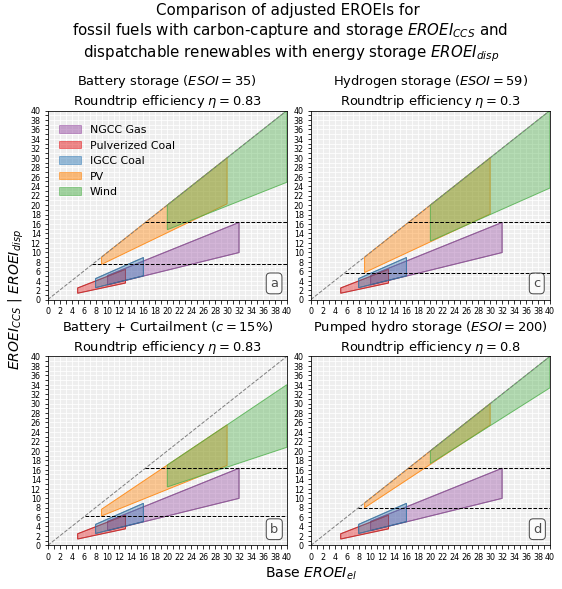

In [62]:
#Plots init
fig,axes=plt.subplots(2,2,figsize=(9,8),subplot_kw=dict(facecolor='#EEEEEE',axisbelow=True))
for axi in axes:
    for ax in axi:
        ax.grid(color='white', linestyle='solid')                       
plt.subplots_adjust(wspace=0.1)
plt.subplots_adjust(hspace=0.3)

#Fossil part
for i in range(len(names)):
    points=[]
    print 'calculating '+names[i].replace('\n',' ')+' convex hull...'
    for eroi in range(len(eroei_el_ns[i])):
        x0=eroei_el_ns[i][eroi]
        y0min=min(eroei_ccs_min_N[i][eroi].flatten())
        y0max=max(eroei_ccs_max_N[i][eroi].flatten())
        points.append([x0,y0min])
        points.append([x0,y0max])
                              
    for axi in axes:
        for ax in axi:
            colr=cbrew(i)
            poly = plt.Polygon(convexhull(points), edgecolor="k",facecolor=colr,alpha=0.4)
            poly2 = plt.Polygon(convexhull(points), edgecolor=colr,alpha=0.8,fill=False,lw=1)
            legendpoly = plt.Polygon([[0,0],[0,-1],[-1,-1]], edgecolor=colr,facecolor=colr,alpha=legendalpha,lw=1,label=names[i].replace('\n',' '))
            ax.add_patch(poly)
            ax.add_patch(poly2)
            ax.add_patch(legendpoly)

#RE part
for i in range(len(eroei_disp_n)):
    print 'calculating '+eroei_ren_names[i]+' convex hull...'
    for j in range(len(eroei_disp_n[i])):
        points=[]
        for eroi in range(len(eroei_disp_n[i][j])):
            x0=eroei_el_ren[i][eroi]
            y0min=min(eroei_disp_n[i][j][eroi].flatten())
            y0max=max(eroei_disp_n[i][j][eroi].flatten())
            points.append([x0,y0min])
            points.append([x0,y0max])

        colr=cbrew(4-i)
        ax=axes[j/2][j%2]
        poly = plt.Polygon(convexhull(points), edgecolor="none",facecolor=colr,alpha=0.4)
        poly2 = plt.Polygon(convexhull(points), edgecolor=colr,alpha=0.8,fill=False,lw=1)
        legendpoly = plt.Polygon([[0,0],[0,-1],[-1,-1]], edgecolor=colr,facecolor=colr,alpha=legendalpha,lw=1,label=eroei_ren_names[i])
        ax.add_patch(poly)
        ax.add_patch(poly2)
        ax.add_patch(legendpoly)
        if (i==0):
            if (j!=2):
                ax.set_title(ESOI_tech[j]+u' ($ESOI='+str(ESOI[j])+\
                     '$)\nRoundtrip efficiency $\eta='+str(eta[j])+'$',fontsize=13)
            else:
                ax.set_title(ESOI_tech[j]+u' ($c='+str(int(c[j]*100))+\
                     '$%)\nRoundtrip efficiency $\eta='+str(eta[j])+'$',fontsize=13)
            ax.text(0.93, 0.12, string.ascii_lowercase[(j%2)*2+j/2],
                    horizontalalignment='left',
                    verticalalignment='top',
                    transform=ax.transAxes,size=13,alpha=0.7,
                    bbox=dict(boxstyle="round", fc="w", alpha=0.7))
            ax.plot([0,100],[0,100],c='grey',lw=1,ls='--')
            ax.plot([re_bottom[j],100],[re_bottom[j],re_bottom[j]],c='k',lw=1,ls='--')
            ax.plot([fs_top,100],[fs_top,fs_top],c='k',lw=1,ls='--')
            
#Format labels
axes[0][0].set_ylabel('$EROEI_{CCS}$ | $EROEI_{disp}$',fontsize=14,y=0)
axes[1][1].set_xlabel('Base $EROEI_{el}$',fontsize=14,x=0)        
maxlabel=max(np.array(eroei_el_ren).flatten())
labelrange=[i if i%2==0 else '' for i in range(int(maxlabel)+1) ]
for axi in axes:
    for ax in axi:
        ax.set_xlim(0,maxlabel)
        ax.set_ylim(0,maxlabel)
        ax.set_xticks(range(int(maxlabel)+1))
        ax.set_yticks(range(int(maxlabel)+1))
        ax.set_yticks(range(int(maxlabel)+1))
        ax.set_xticklabels(labelrange,fontsize=8)   
        ax.set_yticklabels(labelrange,fontsize=8) 

#axes[0][1].legend(loc=(1.04,0.58),fontsize=11)       
axes[0][0].legend(loc=(0.03,0.52),framealpha=0,fontsize=11)       
        
plt.suptitle('Comparison of adjusted EROEIs for \nfossil fuels with carbon-capture and storage $EROEI_{CCS}$ and \ndispatchable renewables with energy storage $EROEI_{disp}$',y=1.06,fontsize=15)
plt.savefig('plot/fig4_annotated.png',dpi=150,bbox_inches = 'tight', pad_inches = 0.1)
plt.show()

Shaded area plots

In [63]:
def alpharater(g,n,t):
    if g<t*n:
        return (g+1)*1.0/(t*n)
    elif g+1>(1-t)*n:
        return ((n-g))*1.0/(t*n)
    else:
        return 1

calculating NGCC Gas convex hull...
calculating Pulverized Coal convex hull...
calculating IGCC Coal convex hull...
calculating PV convex hull...
calculating Wind convex hull...


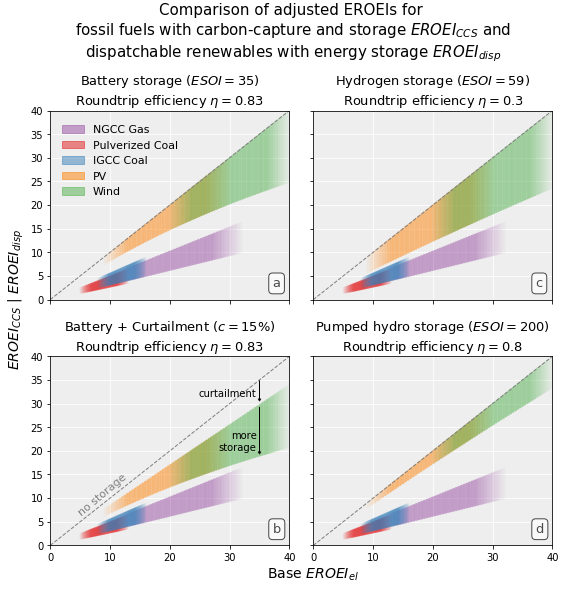

In [64]:
#Plots init
fig,axes=plt.subplots(2,2,figsize=(9,8),subplot_kw=dict(facecolor='#EEEEEE',axisbelow=True))
for axi in axes:
    for ax in axi:
        ax.grid(color='white', linestyle='solid')                       
plt.subplots_adjust(wspace=0.1)
plt.subplots_adjust(hspace=0.3)

#Fossil part
for i in range(len(names)):
    points=[]
    print 'calculating '+names[i].replace('\n',' ')+' convex hull...'
    for eroi in range(len(eroei_el_ns[i])):
        x0=eroei_el_ns[i][eroi]
        y0min=min(eroei_ccs_min_N[i][eroi].flatten())
        y0max=max(eroei_ccs_max_N[i][eroi].flatten())
        points.append([x0,y0min])
        points.append([x0,y0max])
                              
    for axi in axes:
        for ax in axi:
            colr=cbrew(i)
            nfaces=50
            tfaces=0.24
            basealpha=0.5
            for g,p in enumerate(np.split(np.array(points),nfaces)):
                poly = plt.Polygon(convexhull(p), edgecolor=colr,alpha=basealpha*alpharater(g,nfaces,tfaces),fill=False,lw=1.43)
                ax.add_patch(poly)
            poly2 = plt.Polygon(convexhull(points), edgecolor=colr,alpha=0.8,fill=False,lw=1)
            #ax.add_patch(poly2)
            legendpoly = plt.Polygon([[0,0],[0,-1],[-1,-1]], edgecolor=colr,facecolor=colr,alpha=legendalpha,lw=1,label=names[i].replace('\n',' '))
            ax.add_patch(legendpoly)

#RE part
for i in range(len(eroei_disp_n)):
    print 'calculating '+eroei_ren_names[i]+' convex hull...'
    for j in range(len(eroei_disp_n[i])):
        points=[]
        for eroi in range(len(eroei_disp_n[i][j])):
            x0=eroei_el_ren[i][eroi]
            y0min=min(eroei_disp_n[i][j][eroi].flatten())
            y0max=max(eroei_disp_n[i][j][eroi].flatten())
            points.append([x0,y0min])
            points.append([x0,y0max])

        colr=cbrew(4-i)
        ax=axes[j/2][j%2]
        nfaces=50
        tfaces=0.2
        basealpha=0.5
        for g,p in enumerate(np.split(np.array(points),nfaces)):
            poly = plt.Polygon(convexhull(p), edgecolor=colr,alpha=basealpha*alpharater(g,nfaces,tfaces),fill=False,lw=1.25)
            ax.add_patch(poly)
        poly2 = plt.Polygon(convexhull(points), edgecolor=colr,alpha=0.8,fill=False,lw=1)
        #ax.add_patch(poly2)
        legendpoly = plt.Polygon([[0,0],[0,-1],[-1,-1]], edgecolor=colr,facecolor=colr,alpha=legendalpha,lw=1,label=eroei_ren_names[i])
        ax.add_patch(legendpoly)
        if (i==0):
            if (j!=2):
                ax.set_title(ESOI_tech[j]+u' ($ESOI='+str(ESOI[j])+\
                     '$)\nRoundtrip efficiency $\eta='+str(eta[j])+'$',fontsize=13)
            else:
                ax.set_title(ESOI_tech[j]+u' ($c='+str(int(c[j]*100))+\
                     '$%)\nRoundtrip efficiency $\eta='+str(eta[j])+'$',fontsize=13)
            ax.text(0.93, 0.12, string.ascii_lowercase[(j%2)*2+j/2],
                    horizontalalignment='left',
                    verticalalignment='top',
                    transform=ax.transAxes,size=13,alpha=0.7,
                    bbox=dict(boxstyle="round", fc="w", alpha=0.7))
            ax.plot([0,100],[0,100],c='grey',lw=1,ls='--')
            if (j==2): 
                ax.text(0.22, 0.27, 'no storage',
                        horizontalalignment='center',
                        verticalalignment='center',
                        transform=ax.transAxes,size=11,rotation=40, color='grey')
                ax.arrow(35, 35, 0, -4, head_width=0.5, head_length=0.5, fc='k', ec='k',ls='-',lw=0.5)
                ax.arrow(35, 29.3, 0, -9.5, head_width=0.5, head_length=0.5, fc='k', ec='k',ls='-',lw=0.5)
                ax.text(34.5, 32, 'curtailment',
                        horizontalalignment='right',
                        verticalalignment='center', rotation=0, color='k')
                ax.text(34.5, 22, 'more\nstorage',
                        horizontalalignment='right',
                        verticalalignment='center', rotation=0, color='k')
            
#Format labels
for axi in axes:
    for ax in axi:
        ax.set_xlim(0,max(np.array(eroei_el_ren).flatten()))
        ax.set_ylim(0,max(np.array(eroei_el_ren).flatten()))
axes[0][0].set_ylabel('$EROEI_{CCS}$ | $EROEI_{disp}$',fontsize=14,y=0)
axes[1][1].set_xlabel('Base $EROEI_{el}$',fontsize=14,x=0)        
axes[0][1].set_yticklabels('')   
axes[1][1].set_yticklabels('')   
axes[0][0].set_xticklabels('')   
axes[0][1].set_xticklabels('')  
#axes[0][1].legend(loc=(1.04,0.58),fontsize=11)       
axes[0][0].legend(loc=(0.03,0.52),framealpha=0,fontsize=11)       
        
plt.suptitle('Comparison of adjusted EROEIs for \nfossil fuels with carbon-capture and storage $EROEI_{CCS}$ and \ndispatchable renewables with energy storage $EROEI_{disp}$',y=1.06,fontsize=15)
plt.savefig('plot/fig4_shaded.png',dpi=150,bbox_inches = 'tight', pad_inches = 0.1)
plt.show()

### Auxiliary plots

In [49]:
df=pd.read_excel('cfdata.xlsx')

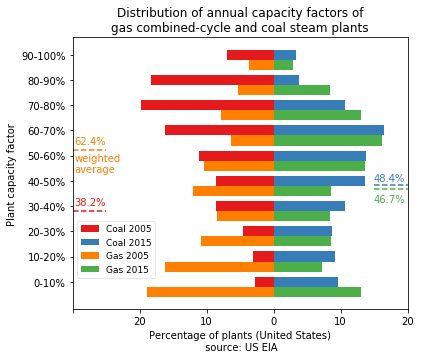

In [56]:
fig,ax=plt.subplots(1,1,figsize=(6,5))
ax.barh(df.index,-df['PC 2005']/sum(df['PC 2005'])*100,0.4,color=cbrew(1),label='Coal 2005')
ax.barh(df.index,df['PC 2015']/sum(df['PC 2015'])*100,0.4,color=cbrew(2),label='Coal 2015')
ax.barh(df.index-0.4,-df['NG 2005']/sum(df['NG 2005'])*100,0.4,color=cbrew(4),label='Gas 2005')
ax.barh(df.index-0.4,df['NG 2015']/sum(df['NG 2015'])*100,0.4,color=cbrew(3),label='Gas 2015')
z=np.average(df.index+0.5,weights=df['NG 2005'])-1
ax.plot([-30,-25],[z,z],ls='--',color=cbrew(1))
ax.text(-29.7,z+0.2,str(np.round((z+1)*10,1))+ '%',color=cbrew(1))
z=np.average(df.index+0.5,weights=df['NG 2015'])-1
ax.plot([15,20],[z,z],ls='--',color=cbrew(2))
ax.text(15,z+0.15,str(np.round((z+1)*10,1))+ '%',color=cbrew(2))
z=np.average(df.index+0.5,weights=df['PC 2005'])-1
ax.plot([-30,-25],[z,z],ls='--',color=cbrew(4))
ax.text(-29.7,z+0.2,str(np.round((z+1)*10,1))+ '%',color=cbrew(4))
ax.text(-29.7,z-0.9,'weighted\naverage',color=cbrew(4))
z=np.average(df.index+0.5,weights=df['PC 2015'])-1
ax.plot([15,20],[z,z],ls='--',color=cbrew(3))
ax.text(15,z-0.5,str(np.round((z+1)*10,1))+ '%',color=cbrew(3))

fig.canvas.draw()
labels = ['']+[item.get_text().replace(u'\u2212','') for item in ax.get_xticklabels()[2:-1]]+['']
ax.set_xticklabels(labels)
ax.set_yticks(df.index)
ax.set_xlim([-30,20])
ax.set_yticklabels(df['CF'][::-1])
ax.legend(bbox_to_anchor=(0.26, 0.22),framealpha=0.5,fontsize=9)
ax.set_ylabel('Plant capacity factor')
ax.set_xlabel('Percentage of plants (United States)\n source: US EIA')
ax.set_title('Distribution of annual capacity factors of\ngas combined-cycle and coal steam plants')
plt.savefig('plot/figS2.png',dpi=150,bbox_inches = 'tight', pad_inches = 0.1)
plt.show()

In [57]:
import seaborn as sns  

In [58]:
dg=[]
fuel_label={'NG':' ','PC':'  '} #just needed for pretty labels
for label in [u'NG 2005', u'NG 2015', u'PC 2015', u'PC 2005']:
    h1=df[[label]]
    for i in h1.index:
        for j in range(int(abs(h1.loc[i][label]))):
            dg.append({'Fuel':fuel_label[label[:2]],'Year':int(label[-4:]),'Capacity factor':(0.5+i)*10})

In [59]:
dh=pd.DataFrame(dg)
dh.head()

,Capacity factor,Fuel,Year
0,5.0,,2005
1,5.0,,2005
2,5.0,,2005
3,5.0,,2005
4,5.0,,2005


C:\Users\csala\AppData\Local\Continuum\anaconda2\envs\python2\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


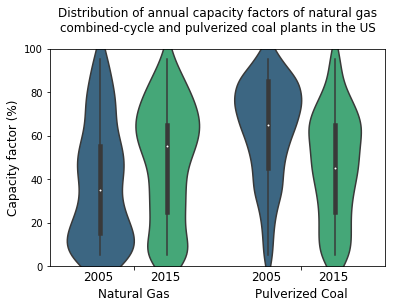

In [60]:
sns.violinplot(data=dh,x='Fuel',hue='Year',y='Capacity factor',palette="viridis")
plt.title('Distribution of annual capacity factors of natural gas\ncombined-cycle and pulverized coal plants in the US',y=1.05)
plt.xlabel('')
plt.ylabel('Capacity factor (%)',fontsize=12)
plt.legend().set_visible(False)
ax=plt.gca()
ax.text(0.1, -0.02, 2005,
                horizontalalignment='left',
                verticalalignment='top',
                transform=ax.transAxes,size=12)
ax.text(0.3, -0.02, 2015,
                horizontalalignment='left',
                verticalalignment='top',
                transform=ax.transAxes,size=12)
ax.text(0.6, -0.02, 2005,
                horizontalalignment='left',
                verticalalignment='top',
                transform=ax.transAxes,size=12)
ax.text(0.8, -0.02, 2015,
                horizontalalignment='left',
                verticalalignment='top',
                transform=ax.transAxes,size=12)
ax.text(0.75, -0.1, 'Pulverized Coal',
                horizontalalignment='center',
                verticalalignment='top',
                transform=ax.transAxes,size=12)
ax.text(0.25, -0.1, 'Natural Gas',
                horizontalalignment='center',
                verticalalignment='top',
                transform=ax.transAxes,size=12)

plt.ylim(0,100)   
plt.savefig('plot/figS2b.png',dpi=150,bbox_inches = 'tight', pad_inches = 0.1)
plt.show()

[Denes Csala](https://csaladen.es) | MIT License | 2018